***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-2.3)** From coarse-to-Fine slowly decrease the dimension. i.e. 32D>16D>8D (Coarse>Medium>FINE), While keeping the primary capsule dimension same as original ($P_{capsule} = 8D$). Training without $L_{cons}$

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD_2\Training_and_Analysis\3_CIFAR-10
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "1" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  1
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


## log directory

In [4]:
directory = sysenv.log_dir('3_CIFAR_10/HD_CapsNet/Mod_2_6')

FOLDER CREATED =  ../../logs/MOD_2/3_CIFAR_10/HD_CapsNet/Mod_2_6


# Import Dataset : CIFAR-10

In [5]:
dataset = datasets.CIFAR10(version = 'ALL') # importing CIFAR10 Dataset
# dataset = datasets.CIFAR10(version = 'reduce') # importing CIFAR10 Dataset

CIFAR-10 dataset: Training have 50,000 samples and testing have 10,000 samples


# Parameters

In [6]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [9]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")
    return total_marginloss

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F):
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*margin_loss(y_true_m, y_pred_m)
    ML_f = LW_F*margin_loss(y_true_f, y_pred_f)
    batch_loss = ML_c + ML_m+ ML_f
    return tf.reduce_mean(batch_loss)

## Model Architecture

In [10]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_ym = dataset['y_train_medium'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = 2
    no_medium_class = 7
    no_fine_class = 10

    PCap_n_dims = 4

    SCap_f_dims = 8
    SCap_m_dims = 16
    SCap_c_dims = 32


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    reshapec = keras.layers.Reshape((int((tf.reduce_prod(x.shape[1:]).numpy())/PCap_n_dims),
                                     PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshapec)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(p_caps)

    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_m_dims, 
                        name="s_caps_medium")(s_caps_c)
    
    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(s_caps_m)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = models.LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_m, y_f],
                        outputs= [pred_c, pred_m, pred_f],
                        name='HD-CapsNet')
    
    keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw']))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [11]:
model = get_compiled_model()

In [12]:
model.summary()

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.math.subtract_3 (TFOpLambda  (None, 7)           0           ['prediction_medium[0][0]']      
 )                                                                                                
                                                                                                  
 tf.math.subtract_4 (TFOpLambda  (None, 7)           0           ['prediction_medium[0][0]']      
 )                                                                                                
                                                                                                  
 tf.math.maximum (TFOpLambda)   (None, 2)            0           ['tf.math.subtract[0][0]']       
                                                                                                  
 tf.math.subtract_2 (TFOpLambda  (None, 2)           0           ['input_yc[0][0]']               
 )        

 da)                                                                                              
                                                                                                  
 tf.math.add_2 (TFOpLambda)     (None, 10)           0           ['tf.math.multiply_8[0][0]',     
                                                                  'tf.math.multiply_10[0][0]']    
                                                                                                  
 tf.math.multiply_3 (TFOpLambda  (None,)             0           ['tf.math.reduce_sum[0][0]']     
 )                                                                                                
                                                                                                  
 tf.math.multiply_7 (TFOpLambda  (None,)             0           ['tf.math.reduce_sum_1[0][0]']   
 )                                                                                                
          

## Data Augmentation

In [13]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [14]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [15]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.3152 - prediction_coarse_accuracy: 0.8544 - prediction_medium_accuracy: 0.4389 - prediction_fine_accuracy: 0.2575
  • Coarse Accuracy = 85.44% | Val_Accuracy = 89.53% | LossWeight = 0.16 
  • Medium Accuracy = 43.89% | Val_Accuracy = 56.37% | LossWeight = 0.42 
  • Fine   Accuracy = 25.75% | Val_Accuracy = 39.19% | LossWeight = 0.42 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.39190, saving model to ../../logs/MOD_2/3_CIFAR_10/HD_CapsNet/Mod_2_6\epoch-best.h5
781/781 [==============================] - 51s 56ms/step - loss: 0.3152 - prediction_coarse_accuracy: 0.8544 - prediction_medium_accuracy: 0.4389 - prediction_fine_accuracy: 0.2575 - val_loss: 0.2244 - val_prediction_coarse_accuracy: 0.8953 - val_prediction_medium_accuracy: 0.5637 - val_prediction_fine_accuracy: 0.3919 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.1833 - prediction_coarse_accuracy: 0.

781/781 [==============================] - ETA: 0s - loss: 0.0726 - prediction_coarse_accuracy: 0.9755 - prediction_medium_accuracy: 0.9282 - prediction_fine_accuracy: 0.8947
  • Coarse Accuracy = 97.55% | Val_Accuracy = 98.07% | LossWeight = 0.19 
  • Medium Accuracy = 92.82% | Val_Accuracy = 90.57% | LossWeight = 0.39 
  • Fine   Accuracy = 89.47% | Val_Accuracy = 86.55% | LossWeight = 0.43 

Epoch 18: val_prediction_fine_accuracy improved from 0.85730 to 0.86550, saving model to ../../logs/MOD_2/3_CIFAR_10/HD_CapsNet/Mod_2_6\epoch-best.h5
781/781 [==============================] - 94s 120ms/step - loss: 0.0726 - prediction_coarse_accuracy: 0.9755 - prediction_medium_accuracy: 0.9282 - prediction_fine_accuracy: 0.8947 - val_loss: 0.0500 - val_prediction_coarse_accuracy: 0.9807 - val_prediction_medium_accuracy: 0.9057 - val_prediction_fine_accuracy: 0.8655 - lr: 6.6342e-04
Epoch 19/100
781/781 [==============================] - ETA: 0s - loss: 0.0704 - prediction_coarse_accuracy: 0.97

781/781 [==============================] - ETA: 0s - loss: 0.0592 - prediction_coarse_accuracy: 0.9830 - prediction_medium_accuracy: 0.9566 - prediction_fine_accuracy: 0.9443
  • Coarse Accuracy = 98.30% | Val_Accuracy = 98.54% | LossWeight = 0.22 
  • Medium Accuracy = 95.66% | Val_Accuracy = 91.77% | LossWeight = 0.40 
  • Fine   Accuracy = 94.43% | Val_Accuracy = 88.36% | LossWeight = 0.38 

Epoch 36: val_prediction_fine_accuracy did not improve from 0.88460
781/781 [==============================] - 96s 122ms/step - loss: 0.0592 - prediction_coarse_accuracy: 0.9830 - prediction_medium_accuracy: 0.9566 - prediction_fine_accuracy: 0.9443 - val_loss: 0.0428 - val_prediction_coarse_accuracy: 0.9854 - val_prediction_medium_accuracy: 0.9177 - val_prediction_fine_accuracy: 0.8836 - lr: 2.6352e-04
Epoch 37/100
781/781 [==============================] - ETA: 0s - loss: 0.0589 - prediction_coarse_accuracy: 0.9822 - prediction_medium_accuracy: 0.9567 - prediction_fine_accuracy: 0.9444
  • Coa

781/781 [==============================] - 103s 132ms/step - loss: 0.0568 - prediction_coarse_accuracy: 0.9825 - prediction_medium_accuracy: 0.9600 - prediction_fine_accuracy: 0.9503 - val_loss: 0.0424 - val_prediction_coarse_accuracy: 0.9832 - val_prediction_medium_accuracy: 0.9222 - val_prediction_fine_accuracy: 0.8871 - lr: 1.6608e-04
Epoch 46/100
781/781 [==============================] - ETA: 0s - loss: 0.0576 - prediction_coarse_accuracy: 0.9839 - prediction_medium_accuracy: 0.9610 - prediction_fine_accuracy: 0.9513
  • Coarse Accuracy = 98.39% | Val_Accuracy = 98.43% | LossWeight = 0.23 
  • Medium Accuracy = 96.10% | Val_Accuracy = 92.31% | LossWeight = 0.40 
  • Fine   Accuracy = 95.13% | Val_Accuracy = 88.96% | LossWeight = 0.37 

Epoch 46: val_prediction_fine_accuracy did not improve from 0.89090
781/781 [==============================] - 100s 128ms/step - loss: 0.0576 - prediction_coarse_accuracy: 0.9839 - prediction_medium_accuracy: 0.9610 - prediction_fine_accuracy: 0.951

781/781 [==============================] - ETA: 0s - loss: 0.0566 - prediction_coarse_accuracy: 0.9838 - prediction_medium_accuracy: 0.9625 - prediction_fine_accuracy: 0.9553
  • Coarse Accuracy = 98.38% | Val_Accuracy = 98.63% | LossWeight = 0.24 
  • Medium Accuracy = 96.25% | Val_Accuracy = 92.42% | LossWeight = 0.40 
  • Fine   Accuracy = 95.53% | Val_Accuracy = 89.42% | LossWeight = 0.36 

Epoch 64: val_prediction_fine_accuracy did not improve from 0.89590
781/781 [==============================] - 80s 102ms/step - loss: 0.0566 - prediction_coarse_accuracy: 0.9838 - prediction_medium_accuracy: 0.9625 - prediction_fine_accuracy: 0.9553 - val_loss: 0.0399 - val_prediction_coarse_accuracy: 0.9863 - val_prediction_medium_accuracy: 0.9242 - val_prediction_fine_accuracy: 0.8942 - lr: 6.2672e-05
Epoch 65/100
781/781 [==============================] - ETA: 0s - loss: 0.0554 - prediction_coarse_accuracy: 0.9843 - prediction_medium_accuracy: 0.9635 - prediction_fine_accuracy: 0.9558
  • Coa

781/781 [==============================] - 60s 77ms/step - loss: 0.0556 - prediction_coarse_accuracy: 0.9827 - prediction_medium_accuracy: 0.9619 - prediction_fine_accuracy: 0.9554 - val_loss: 0.0396 - val_prediction_coarse_accuracy: 0.9864 - val_prediction_medium_accuracy: 0.9253 - val_prediction_fine_accuracy: 0.8930 - lr: 3.9499e-05
Epoch 74/100
781/781 [==============================] - ETA: 0s - loss: 0.0561 - prediction_coarse_accuracy: 0.9836 - prediction_medium_accuracy: 0.9627 - prediction_fine_accuracy: 0.9559
  • Coarse Accuracy = 98.36% | Val_Accuracy = 98.66% | LossWeight = 0.25 
  • Medium Accuracy = 96.27% | Val_Accuracy = 92.65% | LossWeight = 0.40 
  • Fine   Accuracy = 95.59% | Val_Accuracy = 89.42% | LossWeight = 0.35 

Epoch 74: val_prediction_fine_accuracy did not improve from 0.89590
781/781 [==============================] - 66s 84ms/step - loss: 0.0561 - prediction_coarse_accuracy: 0.9836 - prediction_medium_accuracy: 0.9627 - prediction_fine_accuracy: 0.9559 - 

781/781 [==============================] - 98s 125ms/step - loss: 0.0554 - prediction_coarse_accuracy: 0.9840 - prediction_medium_accuracy: 0.9640 - prediction_fine_accuracy: 0.9574 - val_loss: 0.0388 - val_prediction_coarse_accuracy: 0.9866 - val_prediction_medium_accuracy: 0.9277 - val_prediction_fine_accuracy: 0.8958 - lr: 1.4905e-05
Epoch 93/100
781/781 [==============================] - ETA: 0s - loss: 0.0565 - prediction_coarse_accuracy: 0.9832 - prediction_medium_accuracy: 0.9625 - prediction_fine_accuracy: 0.9553
  • Coarse Accuracy = 98.32% | Val_Accuracy = 98.63% | LossWeight = 0.25 
  • Medium Accuracy = 96.25% | Val_Accuracy = 92.57% | LossWeight = 0.40 
  • Fine   Accuracy = 95.53% | Val_Accuracy = 89.44% | LossWeight = 0.35 

Epoch 93: val_prediction_fine_accuracy did not improve from 0.89650
781/781 [==============================] - 99s 127ms/step - loss: 0.0565 - prediction_coarse_accuracy: 0.9832 - prediction_medium_accuracy: 0.9625 - prediction_fine_accuracy: 0.9553 

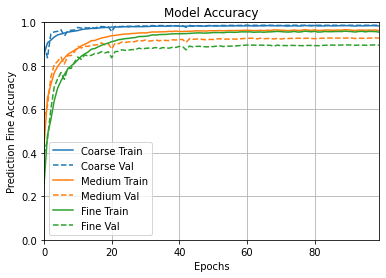

In [16]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])

except:
    print('Trained model weights loaded')

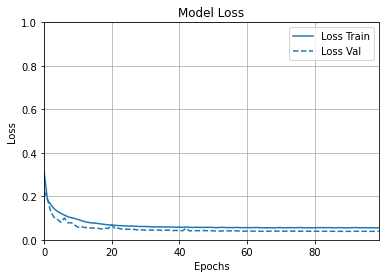

In [17]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])

except:
    print('Trained model weights loaded')

## Model Analysis

In [18]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 16s 39ms/step - loss: 0.0528 - prediction_coarse_loss: 0.0126 - prediction_medium_loss: 0.0539 - prediction_fine_loss: 0.0794 - prediction_coarse_accuracy: 0.9867 - prediction_medium_accuracy: 0.9274 - prediction_fine_accuracy: 0.8945
1. loss ==> 0.05281670391559601
2. prediction_coarse_loss ==> 0.012615656480193138
3. prediction_medium_loss ==> 0.05387137457728386
4. prediction_fine_loss ==> 0.07936619222164154
5. prediction_coarse_accuracy ==> 0.9866999983787537
6. prediction_medium_accuracy ==> 0.9273999929428101
7. prediction_fine_accuracy ==> 0.8945000171661377
313/313 [==============================] - 10s 27ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

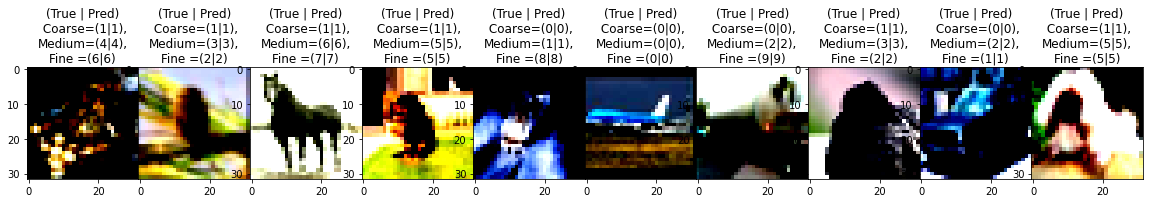

In [19]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[3940   60]
 [  73 5927]]

  • MEDIUM LEVEL 
[[ 925   20   19   18    3    8    7]
 [  28  939   23    1    1    5    3]
 [  13   13 1965    1    5    2    1]
 [  24    2    3  867   27   43   34]
 [   6    1    5   14  946   20    8]
 [  13    2   11   51   53 1789   81]
 [  10    4    5   39   24   75 1843]]

  • FINE LEVEL 
[[931   6  20   4   3   2   2   3  19  10]
 [  5 959   1   0   1   0   2   0   4  28]
 [ 24   1 872  26  20  17  26  10   2   2]
 [  8   2  36 772  22  92  45  15   3   5]
 [  4   2  29  28 886  14  21  13   3   0]
 [  7   1  26 119  19 789  15  21   0   3]
 [  8   1  15  13   6   5 949   1   1   1]
 [  7   0  14  20  22  13   5 914   3   2]
 [ 27   8   4   3   1   0   1   1 942  13]
 [  8  46   0   3   0   0   3   0   9 931]]

  • Classification Report 


  • COARSE LEVEL 


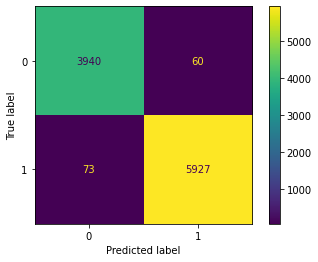

              precision    recall  f1-score   support

           0    0.98181   0.98500   0.98340      4000
           1    0.98998   0.98783   0.98890      6000

    accuracy                        0.98670     10000
   macro avg    0.98589   0.98642   0.98615     10000
weighted avg    0.98671   0.98670   0.98670     10000


  • MEDIUM LEVEL 


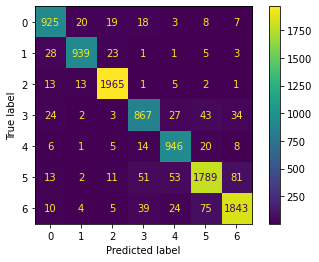

              precision    recall  f1-score   support

           0    0.90775   0.92500   0.91630      1000
           1    0.95719   0.93900   0.94801      1000
           2    0.96750   0.98250   0.97494      2000
           3    0.87487   0.86700   0.87092      1000
           4    0.89330   0.94600   0.91889      1000
           5    0.92122   0.89450   0.90766      2000
           6    0.93222   0.92150   0.92683      2000

    accuracy                        0.92740     10000
   macro avg    0.92201   0.92507   0.92336     10000
weighted avg    0.92750   0.92740   0.92730     10000


  • FINE LEVEL 


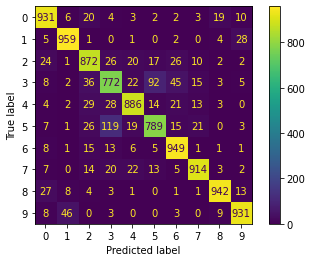

              precision    recall  f1-score   support

           0    0.90476   0.93100   0.91769      1000
           1    0.93470   0.95900   0.94669      1000
           2    0.85742   0.87200   0.86465      1000
           3    0.78138   0.77200   0.77666      1000
           4    0.90408   0.88600   0.89495      1000
           5    0.84657   0.78900   0.81677      1000
           6    0.88775   0.94900   0.91735      1000
           7    0.93456   0.91400   0.92417      1000
           8    0.95538   0.94200   0.94864      1000
           9    0.93568   0.93100   0.93333      1000

    accuracy                        0.89450     10000
   macro avg    0.89423   0.89450   0.89409     10000
weighted avg    0.89423   0.89450   0.89409     10000



In [20]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [21]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.93576 
Hierarchical Recall = 0.9374 
Hierarchical F1-Score = 0.9364357142857143 
Consistency =  0.991 
Exact Match =  0.8916
